In [1]:
!pip install contractions

import pandas as pd
from datetime import datetime
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
import gensim
import contractions
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from keras.layers import Input, Embedding, LSTM, GlobalMaxPool1D, Dense, Dropout, Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
#LOAD DATA
datapath = '../input/kickstarter-projects/ks-projects-201801.csv'

ks = pd.read_csv(datapath)

list(ks.columns)

#PREPARE DAYS COLUMN
def getDays(launch_date, deadline):
    time1 = datetime.strptime(launch_date, '%Y-%m-%d %H:%M:%S')
    date1 = time1.date()
    
    time2 = datetime.strptime(deadline, '%Y-%m-%d')
    date2 = time2.date()
    
    delta = date2 - date1
    days = delta.days
    return days

ks['days'] = ks.apply(lambda x: getDays(x['launched'], x['deadline']), axis=1)
    
#CONVERT OTHER COUNTRIES
def cvtctry(country):
    if country not in ('US', 'GB', 'CA'):
        country = 'OTHER'
        return country
    else:
        country = country
        return country       
    
ks['country'] = ks['country'].apply(lambda x: cvtctry(x))

ks = pd.get_dummies(ks, columns=['main_category'])
ks = pd.get_dummies(ks, columns=['country'])

#REMOVE UNDEFINED AND LIVE CASES
ks.drop(ks[ks['state'] == 'undefined'].index, inplace=True)
ks.drop(ks[ks['state'] == 'live'].index, inplace=True)

def sttlb(state):
    if state == 'successful':
        return 1
    else:
        return 0

ks['label'] = ks['state'].apply(lambda x: sttlb(x))

#PROPROCESS TEXT
ks['name'] = ks['name'].astype(str)
ks['category'] = ks['category'].astype(str)
ks['text'] = ks[['name','category']].agg(' '.join, axis=1)

**I will omit the process of how to make an embedding file with Word2Vec, you can visit [here](https://github.com/xga0/GoodKickOrBadKick) for detailed steps.**

In [3]:
#PREPARE TWO INPUTS
Xt = pd.DataFrame(columns=['text'])
Xt['text'] = ks['text']

Xt['text'] = Xt['text'].apply(lambda x: contractions.fix(x))
Xt['text'] = Xt['text'].apply(lambda x: x.lower())
Xt['text'] = Xt['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
Xt['text'] = Xt['text'].apply(lambda x: x.replace('  ', ' ')) #FIX DOUBLE SPACES GENERATED BY & SIGN

stpw = set(stopwords.words('english'))

def rmvstpw(input_str):
    str_words = input_str.split()
    keep_words = [word for word in str_words if word not in stpw]
    output_str = ' '.join(keep_words)
    return output_str

Xt['text'] = Xt['text'].apply(lambda x: rmvstpw(x))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(Xt['text'].values)
Xt = tokenizer.texts_to_sequences(Xt['text'].values)
Xt = pad_sequences(Xt)

list(ks.columns)

Xn = ks[['usd_goal_real',
 'days',
 'main_category_Art',
 'main_category_Comics',
 'main_category_Crafts',
 'main_category_Dance',
 'main_category_Design',
 'main_category_Fashion',
 'main_category_Film & Video',
 'main_category_Food',
 'main_category_Games',
 'main_category_Journalism',
 'main_category_Music',
 'main_category_Photography',
 'main_category_Publishing',
 'main_category_Technology',
 'main_category_Theater',
 'country_CA',
 'country_GB',
 'country_OTHER',
 'country_US']]

scaler = MinMaxScaler()
Xn[['usd_goal_real']] = scaler.fit_transform(Xn[['usd_goal_real']])
Xn[['days']] = scaler.fit_transform(Xn[['days']])

y = ks['label'].to_list()

Xt_train, Xt_test, y_train, y_test = train_test_split(
        Xt, y, test_size=0.2, random_state=42)

Xn_train, Xn_test, y_train, y_test = train_test_split(
        Xn, y, test_size=0.2, random_state=42)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

In [4]:
#LOAD EMBEDDING
embeddings_index = {}
f = open('../input/kickstarter-word2vec-embedding-file/ks_embedding.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

word_index = tokenizer.word_index

embedding_matrix = np.zeros((len(word_index) + 1, 128))
for word, i in word_index.items():
    if i > len(word_index) + 1:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [5]:
#PREPARE MODEL
input_1 = Input(shape=(Xt.shape[1],))
input_2 = Input(shape=(Xn.shape[1],))

embedding_layer = Embedding(len(word_index) + 1, 128, weights=[embedding_matrix])(input_1)
lstm_layer = LSTM(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(embedding_layer)
globalmaxpool_layer = GlobalMaxPool1D()(lstm_layer)

dense_layer_1 = Dense(32, activation='relu')(input_2)
dropout_layer_1 = Dropout(0.1)(dense_layer_1)
dense_layer_2 = Dense(32, activation='relu')(dropout_layer_1)
dropout_layer_2 = Dropout(0.1)(dense_layer_2)

concat_layer = Concatenate()([globalmaxpool_layer, dropout_layer_2])
dense_layer_3 = Dense(64, activation='relu')(concat_layer)
dropout_layer_3 = Dropout(0.1)(dense_layer_3)

output = Dense(1, activation='sigmoid')(dense_layer_3)

model = Model(inputs=[input_1, input_2], outputs=output)
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

#TRAIN AND TEST
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit([Xt_train, Xn_train], y_train,
                    epochs=1000, batch_size=64, verbose=1,
                    validation_data=([Xt_test, Xn_test], y_test),
                    callbacks=[es])

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 297840 samples, validate on 74460 samples
Epoch 1/1000
297840/297840 [==============================] - 1701s 6ms/step - loss: 0.5631 - accuracy: 0.6980 - val_loss: 0.5498 - val_accuracy: 0.7072
Epoch 2/1000
297840/297840 [==============================] - 1716s 6ms/step - loss: 0.4199 - accuracy: 0.7997 - val_loss: 0.6077 - val_accuracy: 0.6873
Epoch 00002: early stopping


AUC: 0.7194982385577512


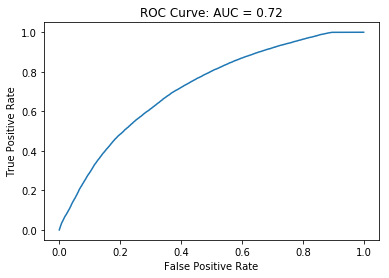

In [6]:
#PLOT
y_pred = model.predict([Xt_test, Xn_test])
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)

auc = np.trapz(tpr,fpr)
print('AUC:', auc)  
plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: AUC = {0:0.2f}'.format(auc))
plt.plot(fpr,tpr)
plt.show()

In [7]:
#ACCURACY
y_pred1 = y_pred > 0.5
metrics.accuracy_score(y_pred1, y_test)

0.6873086220789686

In [8]:
#CONFUSION MATRIX
metrics.confusion_matrix(y_pred1, y_test)

array([[38376, 13904],
       [ 9379, 12801]])